# Overview

Variable selection refers to the process of identifying the most relevant variables in a model from a larger set of predictors. Sometimes we also care about the order in which variables are included in the model. 

We may want to perform variable selection when:

- **We need to reduce measurement costs.** For instance, in medicine, we may have the resources to conduct a pilot study measuring 30 variables for 200 patients but cannot afford to do the same for thousands of people. Similarly, we might be able to install numerous sensors in a field to model crop yields but cannot scale this to cover an entire agricultural region. Cost reduction isn’t always about money or time—when working with humans or animals, it also involves minimizing pain and discomfort.

- **We aim to reduce computational costs.** While computational costs may not be an issue for small, simple models, they can become prohibitive when dealing with many variables, large datasets, or both.

- **We want to better understand important correlation structures.** In other words, we aim to identify which variables contribute the most to making better predictions. Note that this is not about causality. While statistical models, particularly GLMs, can be used for causal inference, doing so requires additional steps and assumptions.

- **We want a model that is more robust to changes in the data-generating distribution.** Variable selection can serve as a way to make a model more resilient to non-representative data.


## How does variable selection work?

There are many methods to perform variable selection, here we will focus on the method implemented in `kulprit`. See here for an alternative approach using [PyMC-BART]().

Kulprit is an implementation of a method known as projective inference. The main idea is that we have a `reference model`, that is a model with all the variables we consider may be relevant (or all the ones we were able to collect) and we are interested in finding a `submodel` with fewer variables.

The Naive approach would be to fit all possible models with different combinations of variables and then compare them under some common metric. However, this is computationally expensive, and time-consuming unless we automatize model creation. 

The solution implemented in `kulprit` is to "project" the reference model's posterior into the submodels. The projection is a procedure that finds the posterior distribution for the submodel inducing a posterior predictive distribution that is as close as possible to the posterior predictive distribution of the reference model. In other words the projection is about finding a submodel that is smaller than the reference model but makes predictions that are as close as possible to it. From a variable selection perspective, this makes sense as we are looking for a model that is simpler but still makes good predictions.


### How that projection is done?

It turns out, that this projection can be framed as an optimization problem. Let's see. 

Denote $\theta$ as the parameter of the posterior from the reference model, and $\theta_\perp$ those of the posterior for a particular submodel. Denote $\tilde{y}$ the samples from the posterior predictive distribution of the reference model $p(\tilde{y} \mid \theta)$. 

Then we want to find a posterior that induces the posterior predictive distribution $q(\tilde{y} \mid \theta_\perp)$. We want $p$ and $q$ to be as close as possible. We can use the [Kullback-Leibler](https://arviz-devs.github.io/Exploratory-Analysis-of-Bayesian-Models/Chapters/Model_comparison.html#entropy) divergence to measure how close two distributions are. Then we can write:

\begin{align}
\mathbb{KL}\{p(\tilde{y}\mid\theta) \lVert q(\tilde{y})\} &= \mathbb{E}_{\tilde{y}\sim p(\tilde{y}\mid\theta)} \left[ \log \frac{p(\tilde{y}\mid\theta)}{q(\tilde{y}\mid\theta_\perp)} \right] \\
&= \underbrace{\mathbb{E}_{\tilde{y}\sim p(\tilde{y}\mid\theta)} \left[ \log p(\tilde{y}\mid\theta)\right]}_{\text{constant}} - \mathbb{E}_{\tilde{y}\sim p(\tilde{y}\mid\theta)} \left[ \log q(\tilde{y}\mid\theta_\perp)\right] \\
&\propto - \mathbb{E}_{\tilde{y}\sim p(\tilde{y}\mid\theta)} \left[ \log q(\tilde{y}\mid\theta_\perp)\right]
\end{align}

In the proposed approach $\log q(\tilde{y} \mid \theta_\perp)$ is the log-likelihood of our model evaluated with respect to samples from the posterior predictive distribution $\tilde{y}\sim p(\tilde{y}\mid\theta)$. Thus to minimize the KL divergence we can maximize the model's log-likelihood with respect to the posterior predictive samples from the reference model. 

In a nutshell, the submodel that maximizes the log-likelihood with respect to the posterior predictive samples from the reference model is the one that is most similar to the reference model.

## What models can I use?

Currently Kulprit can handle only a subset of models supported by Bambi, for example hierarchies are not yet supported. However, the aim is to extend compatibility to all models that can be handled by Bambi.

Another restriction of the current implementation is that the reference model must be a Bambi model and the submodels must be nested models. But in principle we could have a reference model that is a Gaussian Process, or a Neural Network, and submodels that are GLMs.

## Examples

We are going to use two examples to illustrate how to use `kulprit` for variable selection. 

* Body Fat: We will use the bodyfat data set ([Johnson 1996](https://www.tandfonline.com/doi/full/10.1080/10691898.1996.11910505)). The aim of the analysis is to predict an expensive and cumbersome water immersion measurement of body fat percentage (observed variable named `siri`) from a set of thirteen easier to measure characteristics, including `age`, `height`, `weight`, and `circumferences` of various body parts.

* Bikes: This dataset contains the number of bike rentals per hour (`count`) in a bike-sharing system, along with several features that can be used to predict the number of rentals, including `temperature`, `windsepeed`, `hour`, among others. We will use all the variables in the dataset.

In [1]:
import arviz as az
import bambi as bmb
import kulprit as kpt
import numpy as np
import pandas as pd

az.style.use("arviz-white")
SEED = 2935
np.random.seed(SEED)

### Body Fat


The first thing we need to do is to load the data and define a model using Bambi. We are going to use a linear regression with Normal response. We need to set `idata_kwargs={'log_likelihood': True}` as we will later need to compute the [ELPD](https://arviz-devs.github.io/Exploratory-Analysis-of-Bayesian-Models/Chapters/Model_comparison.html#waic) of the reference models and submodels.

In [2]:
body = pd.read_csv("body_fat.csv")
model = bmb.Model("siri ~" +  " + ".join([c for c in body.columns if c!="siri"]), data=body)
idata = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, weight, height, neck, chest, abdomen, hip, thigh, knee, ankle, biceps, forearm, wrist]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


To use Kulprit we first instantiate the `ProjectionPredictive` class and then call the `project` method, which is the one doing all the hard work.

In [3]:
ppi = kpt.ProjectionPredictive(model, idata)
ppi.project()

Once this is finished we can print the `ppi` object. It will give us a list of the submodels in order of lowest ELPD to highest ELPD. The first model is always the intercept-only model.

In [4]:
ppi

  0 []
  1 ['abdomen']
  2 ['abdomen', 'weight']
  3 ['abdomen', 'weight', 'wrist']
  4 ['abdomen', 'weight', 'wrist', 'forearm']
  5 ['abdomen', 'weight', 'wrist', 'forearm', 'age']
  6 ['abdomen', 'weight', 'wrist', 'forearm', 'age', 'neck']
  7 ['abdomen', 'weight', 'wrist', 'forearm', 'age', 'neck', 'ankle']
  8 ['abdomen', 'weight', 'wrist', 'forearm', 'age', 'neck', 'ankle', 'height']
  9 ['abdomen', 'weight', 'wrist', 'forearm', 'age', 'neck', 'ankle', 'height', 'chest']
 10 ['abdomen', 'weight', 'wrist', 'forearm', 'age', 'neck', 'ankle', 'height', 'chest', 'thigh']
 11 ['abdomen', 'weight', 'wrist', 'forearm', 'age', 'neck', 'ankle', 'height', 'chest', 'thigh', 'biceps']
 12 ['abdomen', 'weight', 'wrist', 'forearm', 'age', 'neck', 'ankle', 'height', 'chest', 'thigh', 'biceps', 'hip']
 13 ['abdomen', 'weight', 'wrist', 'forearm', 'age', 'neck', 'ankle', 'height', 'chest', 'thigh', 'biceps', 'hip', 'knee']

We can inspect the `ppi` object manually, but a plot is usually a better idea. By default, the `compare` function plots all the models, including the intercept-only model. In the following block of code, we are asking to omit this model. 


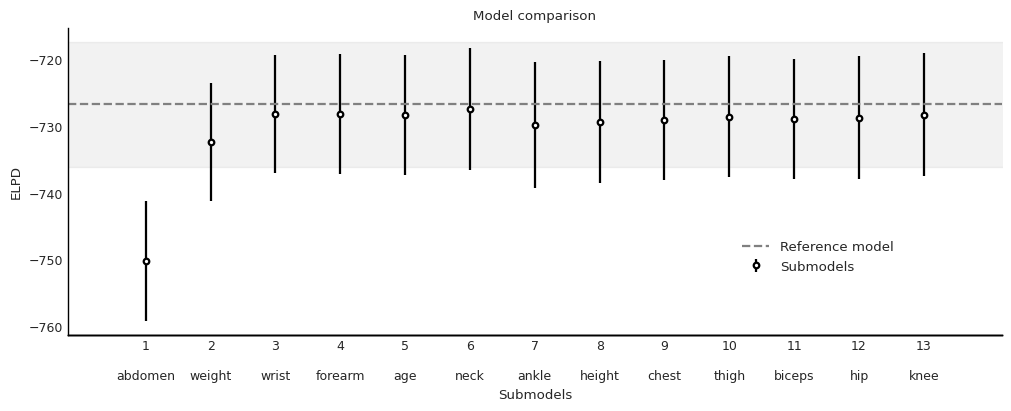

In [5]:
ppi.compare(min_model_size=1);

From this plot we can see that the most relevant variable is `abdomen`, in the sense that if we were forced to pick a single variable, picking `abdomen` would be the one that would make the predictions most similar to the reference model. But the difference of ELPD between the submodel `abdomen` and the reference model is large, so we may want to include more variables. If we include `abdomen` and `weight` and `wrist` we should have model that are statistically indistinguishable from the reference model (under the ELPD metric).

The error bars of the ELPD give us an idea of the uncertainty of the ELPD estimate. This is telling us that if we were to repeat the experiment, it will be unlikely that `abdomen` is not included in the model first, but we may expect some switching between `weight` and `wrist` and even more for the other variables. 

As usual statistical methods should help us make decisions, but they should not make decisions for us. When deciding which variables to include in the model we may prefer an order that is slightly different from the one provided by Kulprit. We may decide that for future measurement we are just going to include `abdomen` and `wrist`, even if this means skipping `weight`. It may be the case that we want to avoid the use of a scale for some reason.

Usually for the purpose of variable selection we do not care about the projections themselves, as they are just an intermediate step to perform variable selecion. Nevertheless, we can explore the projected posterior. The `plot_densities` function allow us to plot the posterior densities of the reference model and the submodel. We can see that the posterior densities of the reference model and the largest submodel (i.e. the reference model projected onto itself) are very similar.

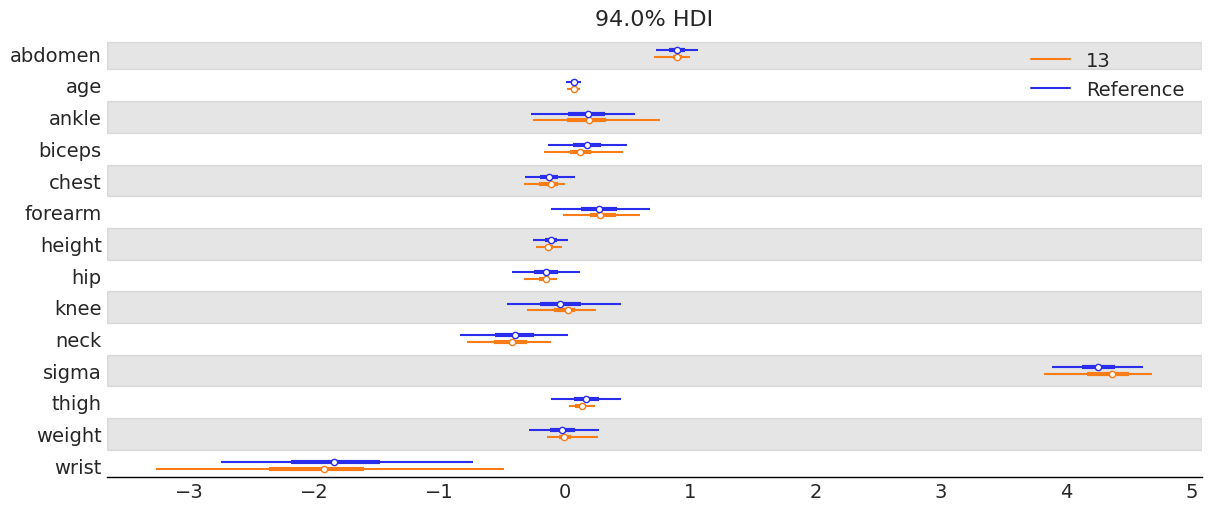

In [6]:
ppi.plot_densities(var_names=["~Intercept", "~mu"],
                   submodels=[13],
                   kind="forest",
                   labels="size",
                   plot_kwargs={"figsize": (12, 5)},
                  );

Below we can see the projection for the submodel of size 3, `abdomen + weight + wrist`.

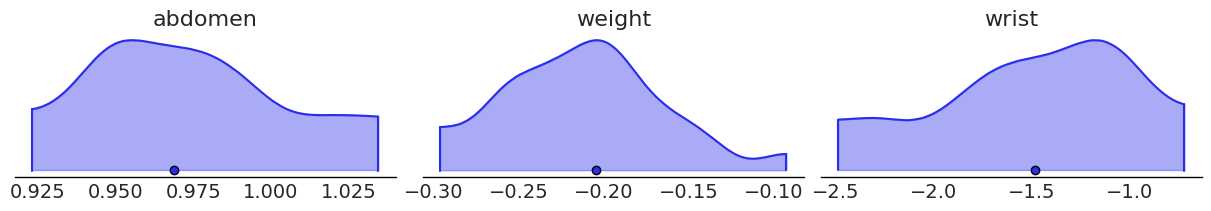

In [7]:
ppi.plot_densities(
                   submodels=[3],
                   include_reference=False,
                   labels="size",
                   figsize=(12, 2),
                   plot_kwargs={"outline": True},
                  );

## Bikes example


In [8]:
bikes = pd.read_csv("bikes.csv")

One thing to note is that a linear model may have difficulties to handle the variable `hour` as it will miss the non-linearities in the data. For instance, we expect rentals to go up in the morning and in the evening, and to go down in the middle of the day and at night.

We could transform the variable `hour` into a set of dummy variables like 
 

```python
bikes = pd.read_csv("bikes.csv")
bikes["hour_sin"] = np.sin(bikes.hour * np.pi / 12)
bikes["hour_cos"] = np.cos(bikes.hour * np.pi / 12)
bikes.drop(columns="hour", inplace=True)
``` 

or we could use a more flexible model like splines (that is also a kind of data transformation). Let's try the latter.

In [9]:
knots = range(1, 22, 5)
priors = {
    "alpha": bmb.Prior("Exponential", lam=1)
}

model = bmb.Model("count ~ bs(hour, knots=knots, intercept=True) + " + " + ".join(bikes.columns.drop(["count", "hour"])),
                  bikes,
                  family="negativebinomial",
                  priors=priors)

This time we are  going to pass Kulprit the Bambi model without fitting it. Kulprit will take care of fitting the model for us by calling PyMC under the hood.

/home/osvaldo/proyectos/00_BM/bambinos/kulprit/kulprit/projector.py:239: UserWarning: No InferenceData object provided. Building posterior from model.
  warnings.warn("No InferenceData object provided. Building posterior from model.")
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, bs(hour, knots=knots, intercept=True), season, month, holiday, weekday, workingday, weather, temperature, humidity, windspeed]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
Sampling: [count]


Output()

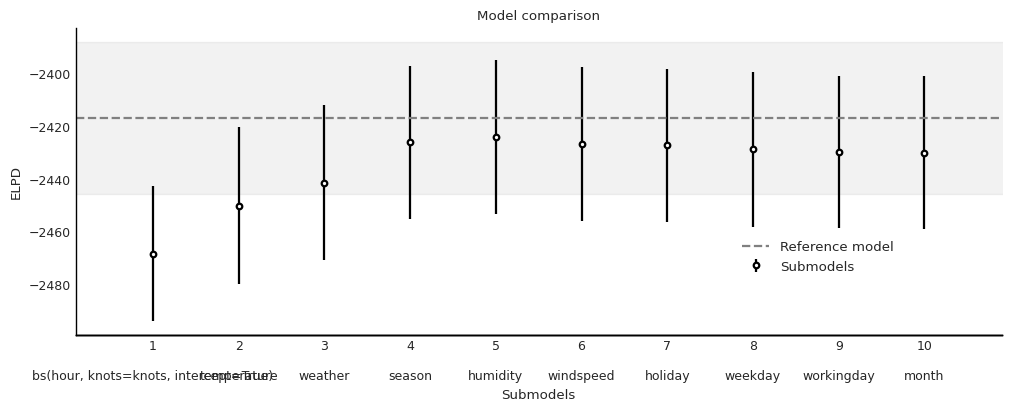

In [10]:
ppi = kpt.ProjectionPredictive(model)
ppi.project()
ppi.compare(min_model_size=1);

We can see that `hour` is the more important variable in the model, followed by `temperature` and `weather` and then the rest of the variables.

## Early stopping

If we have a lot of variables, we may want to stop the projection early. We can do this by setting the `early_stopping` parameter. The are currently two criteria implemented. We are going to use the "se" criterion, which stops the projection when the standard error of the ELPD difference between the submodel and the reference model is smaller than a threshold.

/home/osvaldo/proyectos/00_BM/bambinos/kulprit/kulprit/projector.py:239: UserWarning: No InferenceData object provided. Building posterior from model.
  warnings.warn("No InferenceData object provided. Building posterior from model.")
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, bs(hour, knots=knots, intercept=True), season, month, holiday, weekday, workingday, weather, temperature, humidity, windspeed]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
Sampling: [count]


Output()

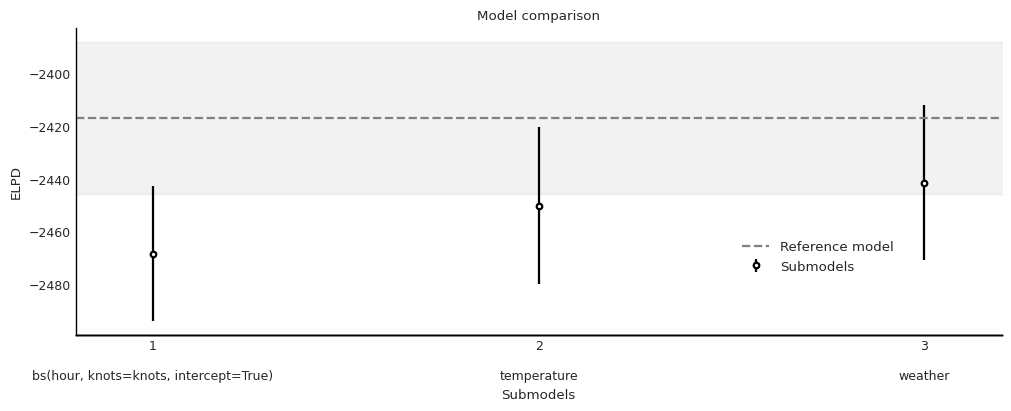

In [11]:
ppi = kpt.ProjectionPredictive(model)
ppi.project(early_stop="se")
ppi.compare(min_model_size=1);